In [1]:
# imports

# python packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.font_manager
import rpy2
from functools import reduce
import xarray as xr

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png
from rpy2.robjects import pandas2ri

# load rpy2 extension for ipython
pandas2ri.activate()
%load_ext rpy2.ipython

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [2]:
# install & import r package sctransform

# check if sctransform is installed
if not ro.packages.isinstalled('sctransform'):
    # select CRAN mirror
    utils = importr('utils')
    utils.chooseCRANmirror(ind=1)
    # install sctransform
    utils.install_packages(ro.vectors.StrVector(['sctransform']))
    
# check if glmGamPoi is installed
if not ro.packages.isinstalled('glmGamPoi'):
    print('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')

# import sctransform
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# should be version 0.3.5 or higher                           
print(sctransform.__version__)


0.3.5.9006


In [3]:
# helper functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount

# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix


# Read in collated mapping counts and metadata

In [4]:
# read in metadata

# filepaths
filepath_genome_metadata = '../../../data/metadata/genome_metadata.csv'
filepath_ortholog_metadata = '../../../data/metadata/ortholog_metadata.csv'
filepath_sample_metadata = '../../../data/metadata/sample_metadata.csv'

# genome metadata
genome_df = pd.read_csv(filepath_genome_metadata)

#  ortholog metadata
ortholog_df = pd.read_csv(filepath_ortholog_metadata)

#  sample metadata
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df['samplename'] = [name[:-2] for name in sample_df['SampleID']]
sample_df = sample_df.rename(columns={'SampleID': 'sample', 'Replicate': 'replicate'})

# create annotations_df to map annotations back to orthologs
annotations_df = ortholog_df[['OrthologID', 'Annotation']].drop_duplicates()
annotations_df = annotations_df.rename(columns={'OrthologID': 'ortholog', 'Annotation': 'annotation'})

sample_df


,sample,Cruise,Dataset,Experiment,Station,Cast,Datetime,Latitude,Longitude,Depth,replicate,SmallFraction,LargeFraction,Unfractionated,Batch,samplename
0,G1.SURF.NS.S02C1.15m.A,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,A,G1.SURF.NS.S02C1.15m.0_2um.A,G1.SURF.NS.S02C1.15m.3um.A,False,G1_SURF,G1.SURF.NS.S02C1.15m
1,G1.SURF.NS.S02C1.15m.B,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,B,G1.SURF.NS.S02C1.15m.0_2um.B,G1.SURF.NS.S02C1.15m.3um.B,False,G1_SURF,G1.SURF.NS.S02C1.15m
2,G1.SURF.NS.S02C1.15m.C,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,C,G1.SURF.NS.S02C1.15m.0_2um.C,G1.SURF.NS.S02C1.15m.3um.C,False,G1_SURF,G1.SURF.NS.S02C1.15m
3,G1.SURF.NS.S04C1.15m.A,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,A,G1.SURF.NS.S04C1.15m.0_2um.A,G1.SURF.NS.S04C1.15m.3um.A,False,G1_SURF,G1.SURF.NS.S04C1.15m
4,G1.SURF.NS.S04C1.15m.B,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,B,G1.SURF.NS.S04C1.15m.0_2um.B,G1.SURF.NS.S04C1.15m.3um.B,False,G1_SURF,G1.SURF.NS.S04C1.15m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,G3.UW.NS.UW40_1.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,B,G3.UW.NS.UW40_1.7m.0_2um.B,G3.UW.NS.UW40_1.7m.3um.B,False,G3_SURF,G3.UW.NS.UW40_1.7m
218,G3.UW.NS.UW40_1.7m.C,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,C,G3.UW.NS.UW40_1.7m.0_2um.C,G3.UW.NS.UW40_1.7m.3um.C,False,G3_SURF,G3.UW.NS.UW40_1.7m
219,G3.UW.NS.UW40_2.7m.A,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,A,G3.UW.NS.UW40_2.7m.0_2um.A,G3.UW.NS.UW40_2.7m.3um.A,False,G3_SURF,G3.UW.NS.UW40_2.7m
220,G3.UW.NS.UW40_2.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,B,G3.UW.NS.UW40_2.7m.0_2um.B,G3.UW.NS.UW40_2.7m.3um.B,False,G3_SURF,G3.UW.NS.UW40_2.7m


In [5]:
# read in mapped transcript abundance data

filepath_data = '../../../data/2-mapping/collated_salmon_data.csv.gz'
mappings_df = pd.read_csv(filepath_data)
mappings_df


,MappingName,GeneLength,TPM,NumReads,SampleID,GenomeName,GeneID
0,AG-311-D23_2717613068,360,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613068
1,AG-311-D23_2717613069,114,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613069
2,AG-311-D23_2717613070,1083,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613070
3,AG-311-D23_2717613071,1053,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613071
4,AG-311-D23_2717613072,1080,0.0,0.0,G3.DIEL.NS.S4C3.15m.C,AG-311-D23,2717613072
...,...,...,...,...,...,...,...
216275059,W9_2553539569,447,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539569
216275060,W9_2553539570,249,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539570
216275061,W9_2553539571,324,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539571
216275062,W9_2553539572,483,0.0,0.0,G2.DCM.NS.S18C2.95m.B,W9,2553539572


# Process mapped reads

- Drop reference genes without ortholog mapping (hypothesized to mostly be small RNA & other highly conserved RNA)
- Within each clade in each sample, aggregate reads mapping to the same ortholog


In [6]:
# directory to store output
output_dir = '../data'


In [7]:
# collect reads mapping to known orthologs only and aggregate within orthologs

pangenome_df = mappings_df[['MappingName', 'SampleID', 'GenomeName', 'NumReads', 'GeneLength']]

# add genus, clade, and ortholog info to dataframe
pangenome_df['Genus'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Genus'])
pangenome_df['Clade'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Clade'])
pangenome_df['OrthologID'] = pangenome_df['MappingName'].map(ortholog_df.set_index('MappingName')['OrthologID'])

# down-select to only the genes with an ortholog mapping
pangenome_df = pangenome_df[~pangenome_df['OrthologID'].isna()]

# aggregate all orthologs in same genus
pangenome_df = pangenome_df.groupby(['SampleID', 'Genus', 'Clade', 
                                  'OrthologID']).agg(Reads=('NumReads', 'sum')).reset_index()

# identify nonzero mappings (at least one read mapped to ortholog-sample-clade)
pangenome_df['Nonzero'] = pangenome_df['Reads'].gt(0.0)

pangenome_df


,SampleID,Genus,Clade,OrthologID,Reads,Nonzero
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000001.0,79.000,True
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000002.0,64.000,True
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000003.0,18.000,True
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000004.0,1583.802,True
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,HLI,60000005.0,814.674,True
...,...,...,...,...,...,...
21847903,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040282.0,0.000,False
21847904,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040288.0,0.000,False
21847905,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040290.0,0.000,False
21847906,G3.UW.NS.UW40_2.7m.C,Synechococcus,Not Assigned,60040293.0,0.000,False


# Separate out data by clade

In [8]:
# separate out data for most highly represented clades in dataset

# thresholds
detection_min = 3 # minimum number of samples a gene must be detected in for each ecotype
coverage_threshold = 0.01 # minimum proportion of detected genes required for each sample included in ecotype subset
clades = {
    'pro': ['HLI', 'HLII', 'LLI'], 
    'syn': ['5.1A-I', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1B-VII', 'CDR2']
}

# storage variables
ortho_list = []
sample_list = []
core_df_dict = {}

for selected_clade in clades['pro'] + clades['syn']:
    print(selected_clade)
    clade_pangenome_df = pangenome_df[pangenome_df.Clade == selected_clade]
    clade_pangenome_df['Batch'] = clade_pangenome_df['SampleID'].map(sample_df.set_index('sample')['Batch'])
    
    # make fresh directory
    dir_path = '{}/{}'.format(output_dir, selected_clade)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    # down-select data to detected orthologs
    core_df = pd.DataFrame(clade_pangenome_df.groupby('OrthologID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.gt(0)] # all detected orthologs
#     core_df = core_df[core_df.Nonzero.ge(detection_min)] # min number of samples
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]

    # down-select to only samples with coverage that is at least x% of the max coverage found in the dataset
    coverage = clade_pangenome_df.groupby('SampleID').Nonzero.sum()
    max_cov = coverage.max()
    total_orthos = len(core_df.index)
    print('Max coverage: {} / {} orthologs ({})'.format(max_cov, total_orthos, max_cov/total_orthos))
    samples = coverage[coverage.gt(coverage.max() * coverage_threshold)].index
    sample_list.append(samples)
    min_cov = coverage[samples].min()
    print('Min coverage: {} / {} orthologs ({})'.format(min_cov, total_orthos, min_cov/total_orthos))
    print('Total samples: {}\n'.format(len(samples)))
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df['SampleID'].isin(samples)]
    
    # down-select data to only orthologs that show up in a minimum number of samples in each batch
    core_df = pd.DataFrame(clade_pangenome_df.groupby(
        ['OrthologID', 'Batch']).Nonzero.sum().ge(detection_min).groupby('OrthologID').sum())
    core_df = core_df[core_df.Nonzero.gt(0)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.OrthologID.isin(core_df.index)]
    ortho_list.append(core_df.index)

    # pivot table
    clade_core_df = clade_pangenome_df.pivot(index='OrthologID', columns=['SampleID'], values='Reads')
    core_df_dict[selected_clade] = clade_core_df
    
    # save pre-normed data to csv
    clade_core_df.to_csv('{}/read_counts_{}.csv'.format(dir_path, selected_clade))
    

HLI
Max coverage: 2798 / 3843 orthologs (0.7280770231589904)
Min coverage: 28 / 3843 orthologs (0.007285974499089253)
Total samples: 175

HLII
Max coverage: 3418 / 4772 orthologs (0.7162615255658005)
Min coverage: 39 / 4772 orthologs (0.008172673931265717)
Total samples: 137

LLI
Max coverage: 3123 / 3587 orthologs (0.870643992194034)
Min coverage: 34 / 3587 orthologs (0.009478672985781991)
Total samples: 129

5.1A-I
Max coverage: 2569 / 3316 orthologs (0.7747285886610374)
Min coverage: 28 / 3316 orthologs (0.008443908323281062)
Total samples: 202

5.1A-II
Max coverage: 2940 / 3361 orthologs (0.8747396608152336)
Min coverage: 33 / 3361 orthologs (0.009818506396905683)
Total samples: 130

5.1A-III
Max coverage: 1881 / 2412 orthologs (0.7798507462686567)
Min coverage: 19 / 2412 orthologs (0.007877280265339967)
Total samples: 123

5.1A-IV
Max coverage: 3063 / 3390 orthologs (0.9035398230088496)
Min coverage: 32 / 3390 orthologs (0.00943952802359882)
Total samples: 207

5.1B-VII
Max covera

In [9]:
# look at intersections of samples and genes

# universal
print('Total cyanobacterial orthologs: {}'.format(len(reduce(np.union1d, ortho_list))))
print('Total cyanobacterial samples: {}'.format(len(reduce(np.union1d, sample_list))))
print('Shared cyanobacterial orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list))))
print('Shared cyanobacterial samples: {}\n'.format(len(reduce(np.intersect1d, sample_list))))

# pro
print('Total Pro orthologs: {}'.format(len(reduce(np.union1d, ortho_list[:3]))))
print('Total Pro samples: {}'.format(len(reduce(np.union1d, sample_list[:3]))))
print('Shared Pro orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[:3]))))
print('Shared Pro samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[:3]))))

# syn
print('Total Syn orthologs: {}'.format(len(reduce(np.union1d, ortho_list[3:]))))
print('Total Syn samples: {}'.format(len(reduce(np.union1d, sample_list[3:]))))
print('Shared Syn orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[3:]))))
print('Shared Syn samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[3:]))))


Total cyanobacterial orthologs: 9309
Total cyanobacterial samples: 222
Shared cyanobacterial orthologs: 1214
Shared cyanobacterial samples: 95

Total Pro orthologs: 5084
Total Pro samples: 178
Shared Pro orthologs: 1710
Shared Pro samples: 122

Total Syn orthologs: 6161
Total Syn samples: 222
Shared Syn orthologs: 1603
Shared Syn samples: 103



In [10]:
# count samples in each batch for each clade

batch_samples = {b: sample_df[sample_df['Batch'] == b]['sample'].tolist() for b in sample_df['Batch'].unique()}
for genus in ['pro', 'syn']:
    for clade in clades[genus]:
        print('\n{}'.format(clade))
        clade_core_df = core_df_dict[clade]
        for batch in sample_df['Batch'].unique():
            samples = [s for s in batch_samples[batch] if s in clade_core_df.columns]
            batch_df = clade_core_df[samples]
            print('\t{}: {} samples'.format(batch, batch_df.shape[1]))
            


HLI
	G1_SURF: 22 samples
	BEXP: 24 samples
	RR_DCM: 33 samples
	G2_SURF: 30 samples
	DEPTH_DIEL: 41 samples
	G3_SURF: 25 samples

HLII
	G1_SURF: 22 samples
	BEXP: 24 samples
	RR_DCM: 32 samples
	G2_SURF: 26 samples
	DEPTH_DIEL: 11 samples
	G3_SURF: 22 samples

LLI
	G1_SURF: 22 samples
	BEXP: 18 samples
	RR_DCM: 27 samples
	G2_SURF: 26 samples
	DEPTH_DIEL: 11 samples
	G3_SURF: 25 samples

5.1A-I
	G1_SURF: 16 samples
	BEXP: 24 samples
	RR_DCM: 43 samples
	G2_SURF: 28 samples
	DEPTH_DIEL: 66 samples
	G3_SURF: 25 samples

5.1A-II
	G1_SURF: 21 samples
	BEXP: 24 samples
	RR_DCM: 31 samples
	G2_SURF: 25 samples
	DEPTH_DIEL: 9 samples
	G3_SURF: 20 samples

5.1A-III
	G1_SURF: 18 samples
	BEXP: 24 samples
	RR_DCM: 29 samples
	G2_SURF: 24 samples
	DEPTH_DIEL: 9 samples
	G3_SURF: 19 samples

5.1A-IV
	G1_SURF: 18 samples
	BEXP: 25 samples
	RR_DCM: 43 samples
	G2_SURF: 30 samples
	DEPTH_DIEL: 66 samples
	G3_SURF: 25 samples

5.1B-VII
	G1_SURF: 20 samples
	BEXP: 17 samples
	RR_DCM: 32 samples
	G2_SU

# Normalize data using sctransform

* Save diagnostic plots & csv files, as well as tensorized data in NetCDF4 format

pro
HLI


R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3070

R[write to console]: Total overdispersed genes: 2982

R[write to console]: Excluding 88 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3070 by 175

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 175 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  10 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 410 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  6.75896004

R[write to console]: Second step: Get residuals using fitted parameters for 3070 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 7.669234 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



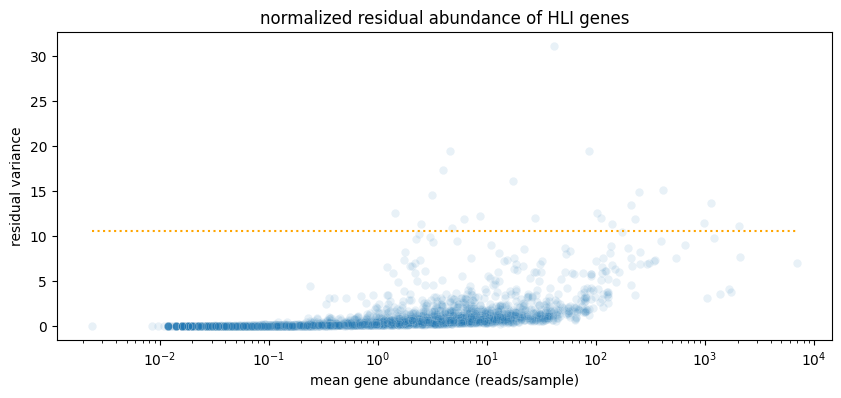

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3556

R[write to console]: Total overdispersed genes: 3436

R[write to console]: Excluding 120 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3556 by 137

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 137 cells



HLII
  |======================================================================| 100%


R[write to console]: Setting estimate of  31 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 772 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  2.56

R[write to console]: Second step: Get residuals using fitted parameters for 3556 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.243617 secs

R[write to console]: In addition: 
R[write to console]: There were 21 warnings (use warnings() to see them)
R[write to console]: 



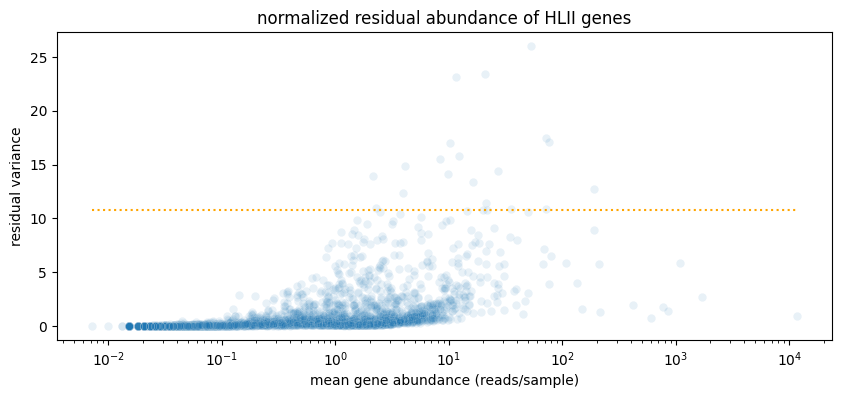

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2775

R[write to console]: Total overdispersed genes: 2734

R[write to console]: Excluding 41 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2775 by 129

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 129 cells



LLI
  |======================================================================| 100%


R[write to console]: Setting estimate of  10 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 673 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2775 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.107943 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



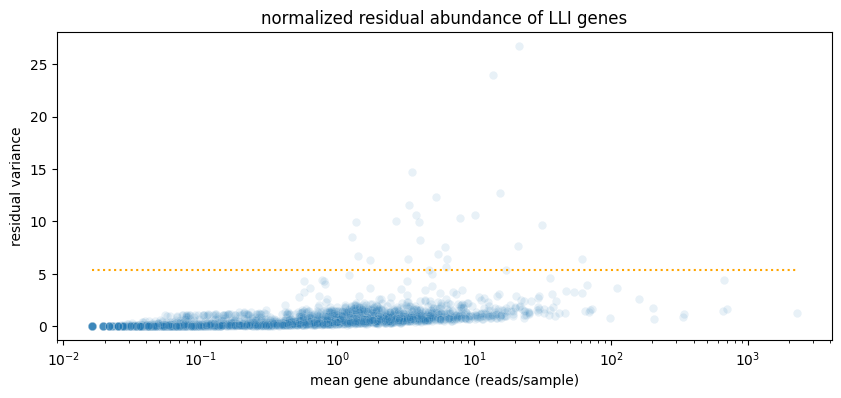

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2832

R[write to console]: Total overdispersed genes: 2784

R[write to console]: Excluding 48 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2832 by 202

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 202 cells



syn
5.1A-I
  |======================================================================| 100%


R[write to console]: Setting estimate of  9 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 546 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2832 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.471258 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



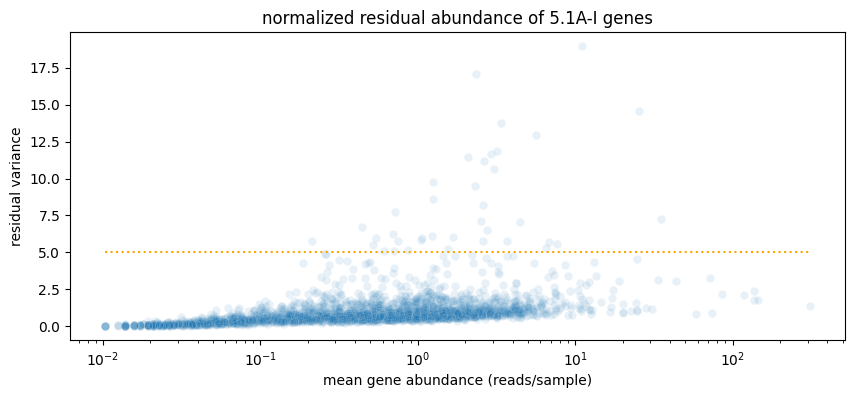

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2969

R[write to console]: Total overdispersed genes: 2928

R[write to console]: Excluding 41 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2969 by 130

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 130 cells



5.1A-II
  |======================================================================| 100%


R[write to console]: Setting estimate of  19 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 793 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2969 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.87811 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



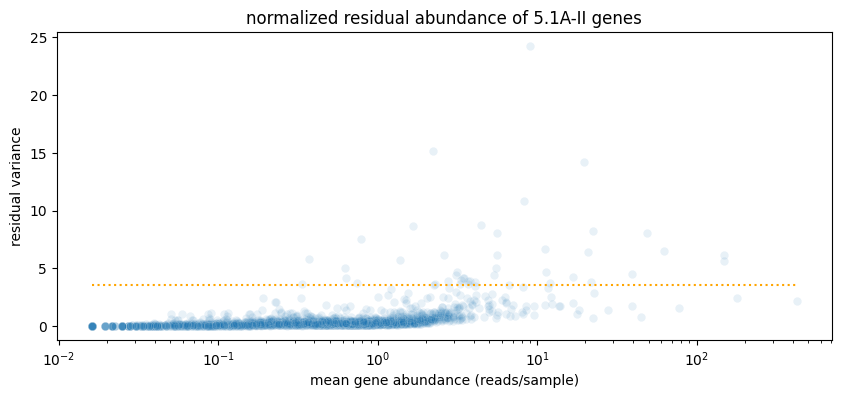

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2007

R[write to console]: Total overdispersed genes: 1958

R[write to console]: Excluding 49 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2007 by 123

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 1958 genes, 123 cells



5.1A-III
  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 745 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2007 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.084731 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



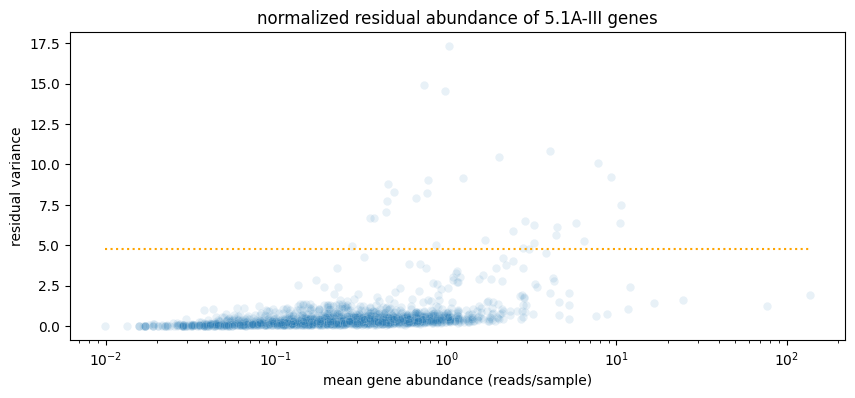

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3120

R[write to console]: Total overdispersed genes: 3094

R[write to console]: Excluding 26 genes from Step 1 because they are not overdispersed.



5.1A-IV


R[write to console]: Variance stabilizing transformation of count matrix of size 3120 by 207

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 207 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  18 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 314 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 3120 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 7.327418 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



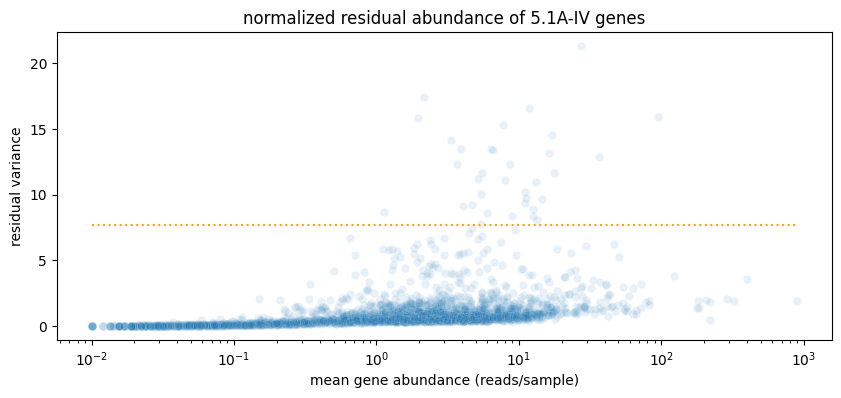

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3574

R[write to console]: Total overdispersed genes: 3522

R[write to console]: Excluding 52 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3574 by 151

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 151 cells



5.1B-VII
  |======================================================================| 100%


R[write to console]: Setting estimate of  25 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 491 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 3574 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.064481 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



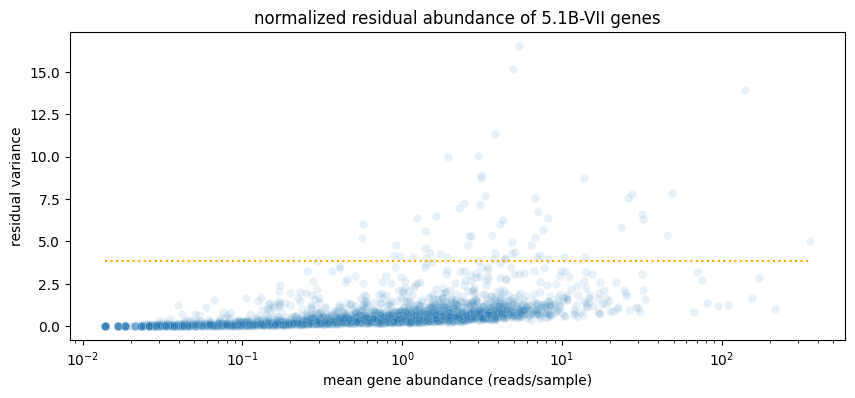

R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2956

R[write to console]: Total overdispersed genes: 2909

R[write to console]: Excluding 47 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2956 by 143

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 143 cells



CDR2
  |======================================================================| 100%


R[write to console]: Setting estimate of  11 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 385 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 2956 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.389069 secs

R[write to console]: In addition: 
R[write to console]: There were 20 warnings (use warnings() to see them)
R[write to console]: 



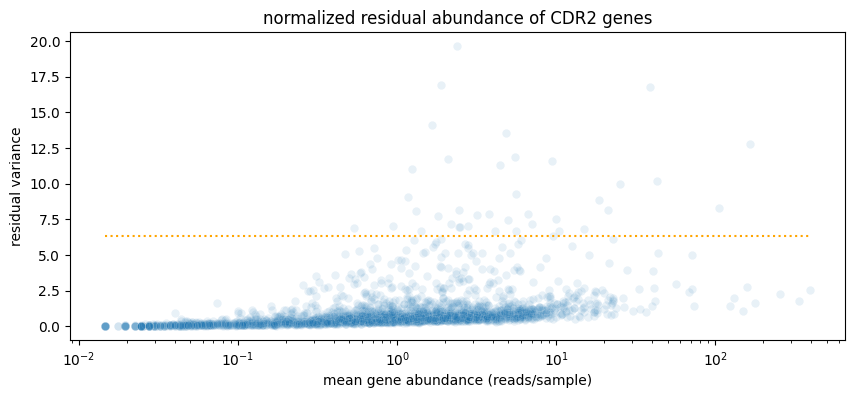

In [11]:
# run the model on each clade, use dataset as covariate to regress out

# store normalized data as slabs to arrange in xarray tensor
read_slabs = {}
residual_slabs = {}

# iterate through pro & syn
for genus in ['pro', 'syn']:
    print(genus)
    read_slabs[genus] = []
    residual_slabs[genus] = []
        
    # iterate through clades
    for clade in clades[genus]:
        print(clade)
        clade_core_df = core_df_dict[clade]
        r_clade_core_df = pandas_dataframe_to_r_matrix(clade_core_df)
        # pull out sample attributes
        sample_attr_df = sample_df.set_index('sample').loc[clade_core_df.columns, ['Dataset', 'Cruise', 'Batch']]
        r_sample_attr_df = pandas2ri.py2rpy(sample_attr_df)

        # make fresh directory
        dir_path = '{}/{}'.format(output_dir, clade)
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)

        # fit vst normalization model
        result = sctransform.vst(
            r_clade_core_df, 
            cell_attr=r_sample_attr_df, 
            batch_var=ro.vectors.StrVector(["Batch"]),
#             method='glmGamPoi', 
            min_cells=detection_min,
            return_gene_attr=True, 
            return_cell_attr=True, 
            vst_flavor='v2', 
            verbosity=10
        )

        # save plot of model parameters
        plots = sctransform.plot_model_pars(result, show_theta=True)
        img = image_png(plots)
        with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
            png.write(img.data)

        # convert residuals result to a dataframe
        residual_df = pd.DataFrame(
            np.asarray(result[0]), 
            index=clade_core_df.index, 
            columns=clade_core_df.columns
        )

        # save residuals as csv
        residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))
        
        # save residuals as slab 
        slab = (
            residual_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='residual')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        residual_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))
        
        # save read counts as slab 
        slab = (
            clade_core_df
            .reset_index()
            .rename(columns={'OrthologID': 'ortholog'})
            .melt(id_vars='ortholog', var_name='sample', value_name='readcount')
        )
        slab['ortholog'] = slab['ortholog'].astype('Int64')
        slab['clade'] = clade
        read_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))

        # plot high variance genes
        residual_var = residual_df.var(axis=1)
        three_sigma = 1 + residual_var.var() * 3
        expression = clade_core_df.apply(geometric_mean, axis=1)
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
        plt.hlines(three_sigma, expression.min(), expression.max(), 
                   colors=['orange'], linestyles=[':'], label='3*sigma');
        plt.xlabel('mean gene abundance (reads/sample)')
        plt.xscale('log')
        plt.ylabel('residual variance')
        plt.title('normalized residual abundance of {} genes'.format(clade))
        plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
        plt.show()

        # save csv of residual variances with annotations
        res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
        res_var_df['Annotation'] = res_var_df.OrthologID.map(annotations_df.set_index('ortholog')['annotation'])
        res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
        res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))
        

In [12]:
# # run the model on each clade, each dataset individually

# # store normalized data as slabs to arrange in xarray tensor
# read_slabs = {}
# residual_slabs = {}
# batch_samples = {b: sample_df[sample_df['Batch'] == b]['sample'].tolist() for b in sample_df['Batch'].unique()}

# # iterate through pro & syn
# for genus in ['pro', 'syn']:
#     print(genus)
#     read_slabs[genus] = []
#     residual_slabs[genus] = []
        
#     # iterate through clades
#     for clade in clades[genus]:
#         print(clade)
#         clade_core_df = core_df_dict[clade]
#         residual_df = pd.DataFrame()

#         # make fresh directory
#         dir_path = '{}/{}'.format(output_dir, clade)
#         if not os.path.isdir(dir_path):
#             os.makedirs(dir_path)
            
#         # normalize each batch on its own
#         for batch in sample_df['Batch'].unique():
#             samples = [s for s in batch_samples[batch] if s in clade_core_df.columns]
#             batch_df = clade_core_df[samples]
#             # drop genes that fall below sample threshold in batch
#             batch_df = batch_df[(batch_df != 0).sum(axis=1).ge(detection_min)]
            
#             # skip over any without cells
#             if len(batch_df) != 0:
#                 # convert batch_df to r matrix
#                 r_batch_df = pandas_dataframe_to_r_matrix(batch_df)

#                 # fit vst normalization model
#                 result = sctransform.vst(
#                     r_batch_df, 
#     #                 cell_attr=r_sample_attr_df, 
#         #             batch_var=ro.vectors.StrVector(["Dataset"]),
#         #             method='glmGamPoi', 
#                     min_cells=detection_min,
#                     return_gene_attr=True, 
#                     return_cell_attr=True, 
#                     vst_flavor='v2', 
#                     verbosity=10
#                 )

#                 # save plot of model parameters
#                 plots = sctransform.plot_model_pars(result, show_theta=True)
#                 img = image_png(plots)
#                 with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
#                     png.write(img.data)

#                 # convert residuals result to a dataframe
#                 result_df = pd.DataFrame(
#                     np.asarray(result[0]), 
#                     index=batch_df.index, 
#                     columns=batch_df.columns
#                 )

#                 # add result to full clade residuals result
#                 if len(residual_df) == 0:
#                     residual_df = result_df.copy()
#                 else:
#                     residual_df = pd.merge(
#                         residual_df, result_df, how='outer', left_index=True, right_index=True).fillna(0)

#         # save residuals as csv
#         residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))
        
#         # save residuals as slab 
#         slab = (
#             residual_df
#             .reset_index()
#             .rename(columns={'OrthologID': 'ortholog'})
#             .melt(id_vars='ortholog', var_name='sample', value_name='residual')
#         )
#         slab['ortholog'] = slab['ortholog'].astype('Int64')
#         slab['clade'] = clade
#         residual_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))
        
#         # save read counts as slab 
#         slab = (
#             clade_core_df
#             .reset_index()
#             .rename(columns={'OrthologID': 'ortholog'})
#             .melt(id_vars='ortholog', var_name='sample', value_name='readcount')
#         )
#         slab['ortholog'] = slab['ortholog'].astype('Int64')
#         slab['clade'] = clade
#         read_slabs[genus].append(slab.set_index(['ortholog', 'clade', 'sample']))

#         # plot high variance genes
#         residual_var = residual_df.var(axis=1)
#         three_sigma = 1 + residual_var.var() * 3
#         expression = clade_core_df.apply(geometric_mean, axis=1)
#         plt.figure(figsize=(10, 4))
#         sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
#         plt.hlines(three_sigma, expression.min(), expression.max(), 
#                    colors=['orange'], linestyles=[':'], label='3*sigma');
#         plt.xlabel('mean gene abundance (reads/sample)')
#         plt.xscale('log')
#         plt.ylabel('residual variance')
#         plt.title('normalized residual abundance of {} genes'.format(clade))
#         plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
#         plt.show()

#         # save csv of residual variances with annotations
#         res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
#         res_var_df['Annotation'] = res_var_df.OrthologID.map(annotations_df.set_index('ortholog')['annotation'])
#         res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
#         res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))
        
# #         https://github.com/satijalab/seurat/issues/3720


In [13]:
# make slabs into xarray tensors and save

# make DataArrays for metadata
replicate_da = xr.DataArray.from_series(sample_df.set_index('sample')['replicate'])
samplename_da = xr.DataArray.from_series(sample_df.set_index('sample')['samplename'])
annotation_da = xr.DataArray.from_series(annotations_df.set_index('ortholog')['annotation'])

for genus in ['pro', 'syn']:
    # make read count DataArray
    read_data = read_slabs[genus]
    read_all_slabs = pd.concat(read_data)
    read_da = xr.DataArray.from_series(read_all_slabs['readcount']).fillna(0)
    # make residual DataArray
    residual_data = residual_slabs[genus]
    residual_all_slabs = pd.concat(residual_data)
    residual_da = xr.DataArray.from_series(residual_all_slabs['residual']).fillna(0)
    # combine residuals with metadata into xarray Dataset
    ds = xr.Dataset(
        dict(
            readcount=read_da, 
            residual=residual_da, 
            replicate=replicate_da.loc[residual_da.sample],
            samplename=samplename_da.loc[residual_da.sample], 
            annotation=annotation_da.loc[residual_da.ortholog]
        )
    )
    # save as netCDF4 file in data directory
    ds.to_netcdf('{}/{}-tensor-dataset.nc'.format(output_dir, genus))

ds
    

<xarray.Dataset>
Dimensions:     (ortholog: 6161, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) object 60000001 60000002 ... 60040219 60040245
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    residual    (ortholog, clade, sample) float64 0.0 0.0 ... -7.014e-07
    replicate   (sample) object 'A' 'B' 'C' 'A' 'B' 'C' ... 'B' 'C' 'A' 'B' 'C'
    samplename  (sample) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS.UW40_2.7m'
    annotation  (ortholog) object 'membrane protease FtsH catalytic subunit' ...